# Overview of data:

This is an adaptation of the hierarchical bootstrap simulation code from https://github.com/soberlab/Hierarchical-Bootstrap-Paper to use to compare ripple abundance between 5XFAD and WT mice.

The original simulation code worked over 2 levels of data - neurons and trials. This data was stored in a 2D array where rows = higher level (neurons) and columns = repetitions w/in that level (trials). Eventually 2 populations of neurons are compared with each other. 

### original simulation dataset
  
#### hierarchy of the data

* neuron 1
    * trial 1
    * trial 2
    * trial n
* neuron 2
    * trial 1
    * trial 2
    * trial n
* neuron n
    * trial 1
    * trial 2
    * trial n

#### structure of the data

    [neuron 1 trial 1, neuron 1 trial 2, neuron 1 trial N;
     neuron 2 trial 1, neuron 2 trial 2, neuron 2 trial N;
     neuron N trial 1, neuron N trial 2, neuron N trial N]

The adapted bootstrapping code must work over 3 levels of data - animals, sessions, and time periods. There are not an equal number of repetitions across any of the levels, so this data is stored in the long data format. That is, a matrix where each row is a single time period, with the animal and session specified. Eventually 2 populations of animals from different genotypes are compared with each other.

### my adapted dataset

#### hierarchy of the data

* genotype 1
    * animal 1
        * session 1
            * period 1
            * period n
        * session 2
            * period 1
            * period n
    * animal n
        * session 1
            * period 1
            * period n
        * session 2
            * period 1
            * period n
* genotype 2
    * animal 1
        * session 1
            * period 1
            * period n
        * session 2
            * period 1
            * period n
    * animal n
        * session 1
            * period 1
            * period n
        * session 2
            * period 1
            * period n
            
#### structure of the data

    [timeperiod 1, session 1, animal1;
     timeperiod 2, session 1, animal1;
     timeperiod N, session 1, animal1;
     timeperiod 1, session N, animal1;
     timeperiod N, session N, animal1;
     timeperiod 1, session 1, animalN;
     timeperiod N, session N, animalN]
    

# Defining functions for bootstrap analysis:

First we will import the relevant libraries that will be used

In [1]:
#Import relevant libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

Three functions are defined below: 
   * _get_bootstrapped_sample_ : a bootstrapping function over that runs nboot times through all levels of a hierarchical dataset.
   * _bootstrap_rec_ : a recursive resampling function that resamples with replacement across all levels of the data.
   * _get_direct_prob_ : A probablity function that can compute the pboot value between two populations of bootstrapped samples.

In [2]:
def get_bootstrapped_sample(variable,levels,nboot=1000):
    '''
    This function performs a hierarchical bootstrap on the data present in 'variable'.
    This function assumes that the data in 'variable' is in the format of a dataframe where the
    input 'levels' indicates which columns contain the data from highest hierarchical level to the lowest.
    '''
    bootstats = np.zeros(nboot)

    #resample with replacement through all of the levels of the data
    for i in np.arange(nboot):
        temp = [];
        rand_lev = np.unique(variable[levels[0]])
        output = bootstrap_rec(variable,rand_lev,levels,temp) #recursive fxn to go through all hierarchical levels

        #calculate the computation of interest (mean ripple rate in our case) here 
        bootstats[i] = np.nanmean(temp)

    return bootstats

In [3]:
def bootstrap_rec(data_input,rand_lev,levels,temp,n=0):
    
    if n == np.shape(levels)[0]-1:                                         #base condition - the lowest level
        temp.extend(rand_lev)                                              #append data at lowest level
        return temp
    else:
        for i in rand_lev:
            #get random sampling of data
            data_temp = data_input[data_input[levels[n]] == i]             #select subset of rows for first level
            data_subset = np.unique(data_temp[levels[n+1]])                #select column with info for next level
            num_subvals = np.shape(data_subset)[0]                         #get number of values within next level
            rand_lev_new = np.random.choice(data_subset,int(num_subvals))  #random sample next level w/replacement
            
#             print('----------------------------------------------------------------- \n'
#                  'There are', num_subvals, levels[n+1], 'values for', levels[n], i, '\n'
#                  'The random samples with replacement are ', rand_lev_new)

            bootstrap_rec(data_input,rand_lev_new,levels,temp,n+1)         #perform bootstrap at next level
        n = n+1                                                            #adjust counter for current level
    
    return temp

In [4]:
def get_direct_prob(sample1, sample2):
    '''
    get_direct_prob Returns the direct probability of items from sample2 being
    greater than or equal to those from sample1.
       Sample1 and Sample2 are two bootstrapped samples and this function
       directly computes the probability of items from sample 2 being greater
       than or equal to those from sample1. Since the bootstrapped samples are
       themselves posterior distributions, this is a way of computing a
       Bayesian probability. The joint matrix can also be returned to compute
       directly upon.
    '''
    joint_low_val = min([min(sample1),min(sample2)])
    joint_high_val = max([max(sample1),max(sample2)])
    
    p_joint_matrix = np.zeros((100,100))
    p_axis = np.linspace(joint_low_val,joint_high_val,num=100)
    edge_shift = (p_axis[2] - p_axis[1])/2
    p_axis_edges = p_axis - edge_shift
    p_axis_edges = np.append(p_axis_edges, (joint_high_val + edge_shift))

    #Calculate probabilities using histcounts for edges.

    p_sample1 = np.histogram(sample1,bins=p_axis_edges)[0]/np.size(sample1)
    p_sample2 = np.histogram(sample2,bins=p_axis_edges)[0]/np.size(sample2)

    #Now, calculate the joint probability matrix:

    for i in np.arange(np.shape(p_joint_matrix)[0]):
        for j in np.arange(np.shape(p_joint_matrix)[1]):
            p_joint_matrix[i,j] = p_sample1[i]*p_sample2[j]
            
    #Normalize the joint probability matrix:
    p_joint_matrix = p_joint_matrix/np.sum(p_joint_matrix)
    
    #Get the volume of the joint probability matrix in the upper triangle:
    p_test = np.sum(np.triu(p_joint_matrix))
    
    return p_test, p_joint_matrix

# Data cleaning and analysis:

### Step 1 - Loading and splitting up the data by genotype

We want to compare all of the time periods recorded from X number of sessions from 9 animals in the two different 5XFAD and WT groups. First we will clean the data by splitting it up into the 5XFAD and WT groups.

First load in the data frame. Then select the 5XFAD and WT subsets of the original data frame based on their genotype ID.

In [5]:
df = pd.read_csv("ripRateTable5to2000s.csv")
data_FAD = df[df.genotypeID == 1] #1 indicates FAD 
data_WT = df[df.genotypeID == 2] #2 indicates WT
df.head()

,riprates,genotypeID,anID,sessID,periodID
0,0.0,2,8,1,1
1,0.0,2,8,1,2
2,0.0,2,8,1,3
3,0.0,2,8,1,4
4,0.0,2,8,1,5


### Step 2 - Calculating traditional statistics

Get the traditional statistics for the data using all of the samples

In [28]:
#Get ranksum p-value for traditional calculation:
ranksum_results = stats.ranksums(data_FAD.riprates,data_WT.riprates)[1]

#Get SEMs for the same:
ranksum_sem_FAD = np.std(data_FAD.riprates)/np.sqrt(np.size(data_FAD.riprates))
ranksum_sem_WT = np.std(data_WT.riprates)/np.sqrt(np.size(data_WT.riprates))
ranksum_mean_FAD = np.nanmean(data_FAD.riprates)
ranksum_mean_WT = np.nanmean(data_WT.riprates)

print("Traditional rank sum p-value:", ranksum_results)

Traditional rank sum p-value: 1.917061145057577e-16


### Step 3 - Calculating summarized statistics

Get the summarized statistics for the data by getting an average ripple rate for each animal across all sessions and time periods

In [29]:
#Get the summarized values for each animal for each genotype:
iden_an_FAD = np.unique(data_FAD.anID)
mean_an_FAD = [] #initialize data struct
for i in iden_an_FAD:
    an_data = data_FAD[data_FAD.anID == i]
    an_mean = np.nanmean(an_data.riprates) #get average ripple rate for each animal across sessions/timeperiods
    mean_an_FAD = np.append(mean_an_FAD, an_mean)
    
iden_an_WT = np.unique(data_WT.anID)
mean_an_WT = [] #initialize data struct
for i in iden_an_WT:
    an_data = data_WT[data_WT.anID == i]
    an_mean = np.nanmean(an_data.riprates) #get average ripple rate for each animal across sessions/timeperiods
    mean_an_WT = np.append(mean_an_WT, an_mean)
    
#Get ranksum p-value for summarized calculation:
ranksum_sum_results = stats.ranksums(mean_an_FAD,mean_an_WT)[1]
#Get SEMs for the same:
ranksum_sum_sem_FAD = np.std(mean_an_FAD)/np.sqrt(np.size(mean_an_FAD))
ranksum_sum_sem_WT = np.std(mean_an_WT)/np.sqrt(np.size(mean_an_WT))
ranksum_sum_mean_FAD = np.nanmean(mean_an_FAD)
ranksum_sum_mean_WT = np.nanmean(mean_an_WT)

print("5XFAD means are", mean_an_FAD, "\nWT means are", mean_an_WT)
print("Summarized statistics rank sum p-value:", ranksum_sum_results)

5XFAD means are [0.00516463 0.00104937 0.00650678 0.04743681 0.03454172] 
WT means are [0.14861612 0.01472387 0.12741749 0.03519837]
Summarized statistics rank sum p-value: 0.0864107329737


### Step 4 - Calculating the bootstrap statistics

Now we will get the bootstrapped samples and probability for the hierarchical bootstrap statistics

In [8]:
n_runs = 10
bootstrap_results = np.zeros((n_runs,3))

for i in np.arange(n_runs):
    
    #define the levels we will use (ordered from highest to lowest)
    levels = ['anID','sessID','riprates'];
    
    #calculate bootstrapped samples:
    bootstats_FAD = get_bootstrapped_sample(data_FAD, levels)
    bootstats_WT = get_bootstrapped_sample(data_WT, levels)
    
    #Calculate probability of bootstats2 >= bootstats1:
    bootstrap_results[i,0] = get_direct_prob(bootstats_FAD,bootstats_WT)[0]
    
    #Get SEM from bootstrapped samples:
    bootstrap_results[i,1] = np.std(bootstats_FAD)
    bootstrap_results[i,2] = np.std(bootstats_WT)
    
    print("Run {} completed".format(i))
    

Run 0 completed
Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed


Now we will concatenate the results across different statistical tests and bootstrap runs. We will save these results since this code can take a long time to run.

In [31]:
#concatenate results across all runs
results = np.zeros((n_runs,3))
sem_results = np.zeros((n_runs,6))
mean_results = np.zeros((n_runs,6))
for i in np.arange(n_runs):
    #fill in the output data structure with the results
    results[i,0] = ranksum_results
    results[i,1] = ranksum_sum_results
    results[i,2] = bootstrap_results[i,1]
    mean_results[i,0] = ranksum_mean_FAD
    mean_results[i,1] = ranksum_mean_WT
    mean_results[i,2] = ranksum_sum_mean_FAD
    mean_results[i,3] = ranksum_sum_mean_WT
    mean_results[i,4] = bootstrap_results[i,1]
    mean_results[i,5] = bootstrap_results[i,2]
    
    sem_results[i,0] = ranksum_sem_FAD
    sem_results[i,1] = ranksum_sem_WT
    sem_results[i,2] = ranksum_sum_sem_FAD
    sem_results[i,3] = ranksum_sum_sem_WT
    sem_results[i,4] = bootstrap_results[i,1]
    sem_results[i,5] = bootstrap_results[i,2]
    
#Get the proportion of significant differences:
prop_of_sig_results = np.zeros(3)
prop_of_sig_results[0] = np.sum(results[:,0]<0.05)/np.size(results[:,0]) #ranksum
prop_of_sig_results[1] = np.sum(results[:,1]<0.05)/np.size(results[:,1]) #ranksum sum
prop_of_sig_results[2] = np.sum((results[:,2]<0.05) | (results[:,2]>0.95))/np.size(results[:,0]) #bootstrap

#Save the measures of the SEM:
sem_summaries = np.zeros(6)
sem_summaries[0] = np.mean(sem_results[:,:2])    # ranksum traditional stats
sem_summaries[1] = np.std(sem_results[:,:2])
sem_summaries[2] = np.mean(sem_results[:,2:4])   # ranksum summarized stats
sem_summaries[3] = np.std(sem_results[:,2:4])
sem_summaries[4] = np.mean(sem_results[:,4:])    # bootstrap
sem_summaries[5] = np.std(sem_results[:,4:])

#save the output to a text file
np.savetxt('sig_results_riprates_5XADvsWT.csv',prop_of_sig_results,delimiter=',')
np.savetxt('sem_summaries_riprates_5XADvsWT.csv',sem_summaries,delimiter=',')
np.savetxt('pvalues_full_riprates_5XADvsWT.csv',results,delimiter=',')

In [13]:
#Load the saved values into the corresponding variable names:
prop_of_sig_results = np.loadtxt('sig_results_riprates_5XADvsWT.csv',delimiter=',')
sem_summaries = np.loadtxt('sem_summaries_riprates_5XADvsWT.csv',delimiter = ',')
results = np.loadtxt('pvalues_full_riprates_5XADvsWT.csv',delimiter=',')

### Step 5 - Plotting the results

Now we will plot the ripple abundance results between these two groups using the standard errors from the three statistical tests

<IPython.core.display.Javascript object>


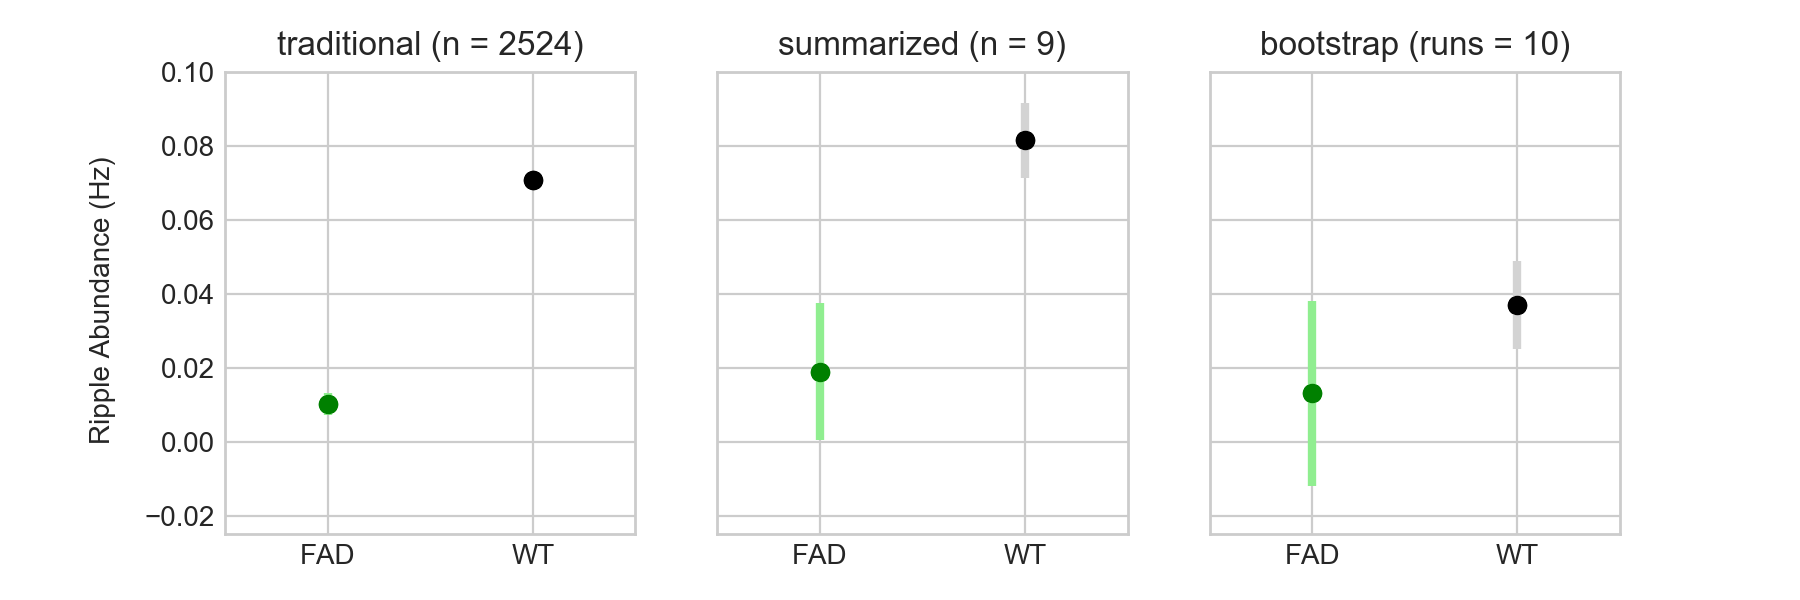

<IPython.core.display.Javascript object>


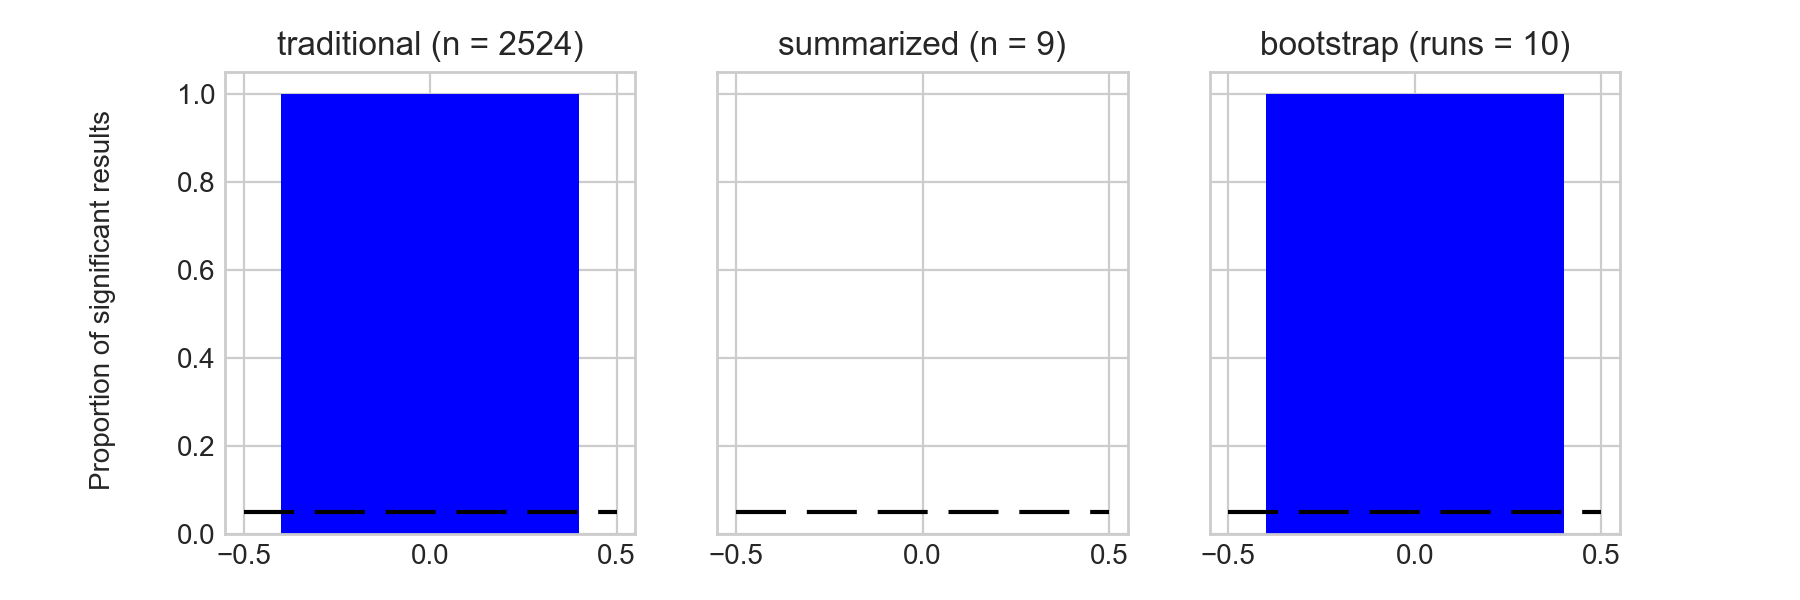

In [125]:
labels = ['traditional (n = {})'.format(np.size(data_WT.riprates) + np.size(data_FAD.riprates)),
          'summarized (n = {})'.format(np.size(mean_an_WT) + np.size(mean_an_FAD)),
          'bootstrap (runs = {})'.format(n_runs)]
xlabels = ['FAD', 'WT']
plt.style.use('seaborn-whitegrid')

#plot data with means and sems for all statistical tests
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
fig.text(0.05, 0.5, 'Ripple Abundance (Hz)', va='center',rotation=90)
counter = 0
for i in np.arange(0,6,2): #5XFAD are all the odds
    axs[counter].errorbar(0, np.mean(mean_results[:,i]), yerr=sem_summaries[i], fmt='o', color='green', ecolor='lightgreen', elinewidth=3, capsize=0);
    axs[counter].errorbar(1, np.mean(mean_results[:,i+1]), yerr=sem_summaries[i+1], fmt='o', color='black', ecolor='lightgray', elinewidth=3, capsize=0);
    axs[counter].scatter('FAD', np.mean(mean_results[:,i]), color='green')
    axs[counter].scatter('WT', np.mean(mean_results[:,i+1]), color='black')
    axs[counter].set_title(labels[counter])
    axs[counter].set_ylim(-0.025,0.1)
    axs[counter].set_xlim(-0.5,1.5)
    counter += 1
    
#plot proportion of significant results for all statistical tests
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
fig.text(0.05, 0.5, 'Proportion of significant results', va='center',rotation=90)
counter = 0
for i in np.arange(0,3):
    axs[counter].bar(0,prop_of_sig_results[i], color='blue')
    axs[counter].set_title(labels[counter])
    axs[counter].plot([-0.5, 0.5],[0.05, 0.05],color='k',dashes=[12,5],label = '5% level')
    counter += 1